<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/ReviewTokoBaju_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/1a62c814ab2a0a1c080e04391824de60a70e76e0/02.%20Deep%20Learning/05.%20Week%205/Datasets/ReviewTokoBaju.csv"
df = pd.read_csv(url)
df.columns = df.columns.str.strip()  # Bersihkan spasi di nama kolom

# Rename untuk konsistensi (optional)
df = df.rename(columns={"Review Text": "review", "Recommended IND": "label"})

# Info dasar
print("Dataset shape:", df.shape)
print("\nKolom:", df.columns.tolist())
print("\nLabel Distribution:")
print(df['label'].value_counts())

# Contoh review
print("\nContoh Review Positif:")
print(df[df['label'] == 1]['review'].dropna().sample(3).values)

print("\nContoh Review Negatif:")
print(df[df['label'] == 0]['review'].dropna().sample(3).values)


Dataset shape: (23486, 11)

Kolom: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'review', 'Rating', 'label', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']

Label Distribution:
label
1    19314
0     4172
Name: count, dtype: int64

Contoh Review Positif:
['Purchased the daisy sleep top to go with the matching shorts. i had been eyeing them for awhile in the store and so glad i took the plunge to get the set. i feel feminine and sexy as another reviewer noted while not being revealing (helpful for visitors and children :). i purchased a s as it does run a bit large.'
 "I ordered this on-line. i love the sleeves and the pleat in the back, but the top runs large. i ordered a small, but it is too big. other reviews say that the top shrinks when you wash it. however, i'm not sure if the store would let me return a washed item if it doesn't shrink enough for my taste. i think i will probably be returning this top."
 "I love this! very comfortable & cute dress. 

In [ ]:
# Parameters
vocab_size = 10000
max_length = 100
oov_token = "<OOV>"

# Clean text: lowercase & remove punctuation
df['cleaned_review'] = df['review'].astype(str).str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)

df = df[df['cleaned_review'].str.strip() != ""]

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['cleaned_review'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# Padding
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Labels
labels = np.array(df['label'])


In [ ]:
def build_model(model_type="LSTM", vocab_size=10000, embedding_dim=64, max_length=100, rnn_units=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

    # Tambahan stabilisasi
    model.add(Dropout(0.3))  # Tambahan dropout setelah embedding
    model.add(BatchNormalization())

    # Layer RNN sesuai pilihan
    if model_type == "RNN":
        model.add(SimpleRNN(rnn_units, return_sequences=False))
    elif model_type == "LSTM":
        model.add(LSTM(rnn_units, return_sequences=False))
    elif model_type == "GRU":
        model.add(GRU(rnn_units, return_sequences=False))
    else:
        raise ValueError("Invalid model_type: choose from 'RNN', 'LSTM', or 'GRU'")

    model.add(Dropout(dropout_rate))  # Dropout setelah RNN
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)


In [ ]:
def train_and_plot(model, X_train, y_train, X_test, y_test, model_name="Model"):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )

    # Convert accuracy to percentage
    acc = [x * 100 for x in history.history['accuracy']]
    val_acc = [x * 100 for x in history.history['val_accuracy']]

    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.yticks(np.arange(70, 101, 5))  # Ubah sesuai range akurasimu
    plt.ylim(70, 100)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0.3, 0.65, 0.05))  # skala halus dan rapi
    plt.ylim(0.3, 0.6)  # batas bawah & atas sumbu Y
    plt.legend()

    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history


Epoch 1/10
294/294 - 10s - 35ms/step - accuracy: 0.7932 - loss: 0.5298 - val_accuracy: 0.8223 - val_loss: 0.4767 - learning_rate: 1.0000e-03
Epoch 2/10
294/294 - 3s - 9ms/step - accuracy: 0.8181 - loss: 0.4869 - val_accuracy: 0.8214 - val_loss: 0.4704 - learning_rate: 1.0000e-03
Epoch 3/10
294/294 - 6s - 19ms/step - accuracy: 0.8217 - loss: 0.4740 - val_accuracy: 0.8216 - val_loss: 0.4710 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
294/294 - 5s - 16ms/step - accuracy: 0.8239 - loss: 0.4647 - val_accuracy: 0.8214 - val_loss: 0.4714 - learning_rate: 1.0000e-03
Epoch 5/10
294/294 - 5s - 17ms/step - accuracy: 0.8305 - loss: 0.4487 - val_accuracy: 0.8191 - val_loss: 0.4762 - learning_rate: 5.0000e-04


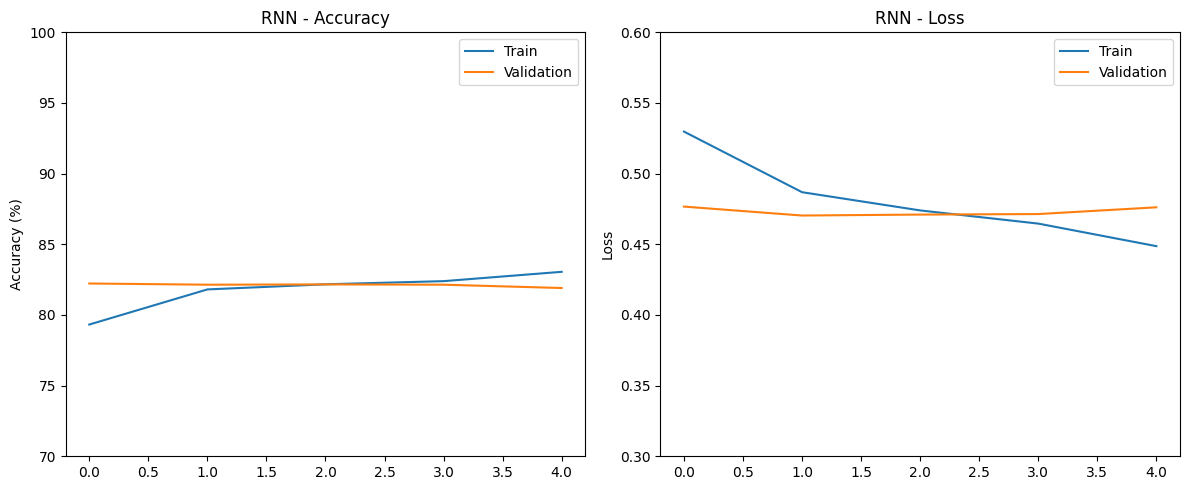

In [ ]:
# RNN
rnn_model = build_model(model_type="RNN")
rnn_model, rnn_history = train_and_plot(rnn_model, X_train, y_train, X_test, y_test, "RNN")

Epoch 1/10
294/294 - 5s - 18ms/step - accuracy: 0.8163 - loss: 0.4846 - val_accuracy: 0.8223 - val_loss: 0.5016 - learning_rate: 1.0000e-03
Epoch 2/10
294/294 - 3s - 10ms/step - accuracy: 0.8181 - loss: 0.4626 - val_accuracy: 0.8223 - val_loss: 0.4682 - learning_rate: 1.0000e-03
Epoch 3/10
294/294 - 3s - 10ms/step - accuracy: 0.8223 - loss: 0.4711 - val_accuracy: 0.8233 - val_loss: 0.4612 - learning_rate: 1.0000e-03
Epoch 4/10
294/294 - 5s - 17ms/step - accuracy: 0.8199 - loss: 0.4004 - val_accuracy: 0.8487 - val_loss: 0.4208 - learning_rate: 1.0000e-03
Epoch 5/10
294/294 - 6s - 20ms/step - accuracy: 0.8481 - loss: 0.3317 - val_accuracy: 0.8235 - val_loss: 0.3498 - learning_rate: 1.0000e-03
Epoch 6/10
294/294 - 5s - 16ms/step - accuracy: 0.8938 - loss: 0.2623 - val_accuracy: 0.8772 - val_loss: 0.2892 - learning_rate: 1.0000e-03
Epoch 7/10
294/294 - 5s - 18ms/step - accuracy: 0.9047 - loss: 0.2345 - val_accuracy: 0.8840 - val_loss: 0.3366 - learning_rate: 1.0000e-03
Epoch 8/10

Epoch 8:

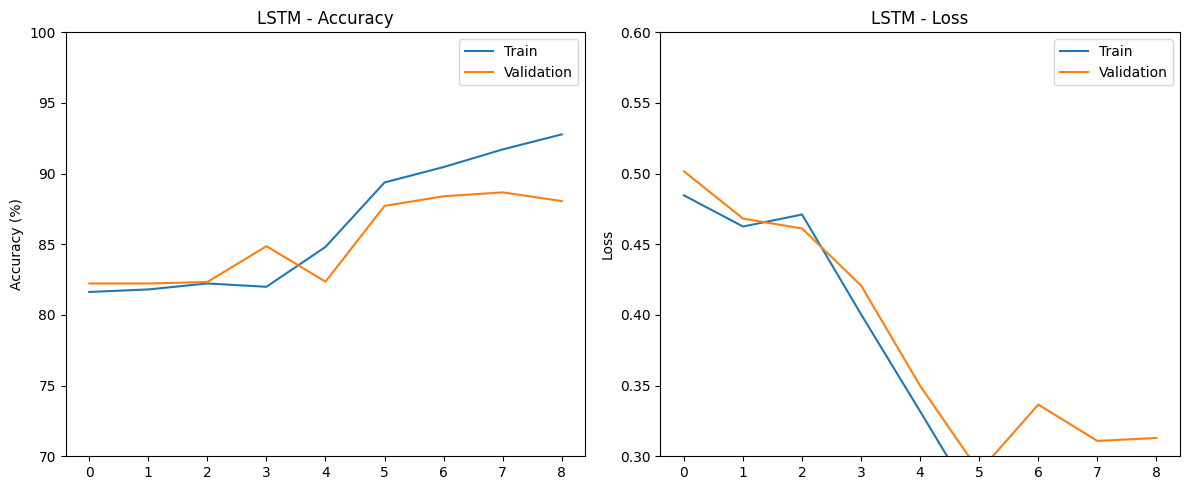

In [ ]:
# LSTM
lstm_model = build_model(model_type="LSTM")
lstm_model, lstm_history = train_and_plot(lstm_model, X_train, y_train, X_test, y_test, "LSTM")

Epoch 1/10
294/294 - 5s - 17ms/step - accuracy: 0.8148 - loss: 0.4885 - val_accuracy: 0.8223 - val_loss: 0.4890 - learning_rate: 1.0000e-03
Epoch 2/10
294/294 - 5s - 18ms/step - accuracy: 0.8222 - loss: 0.4704 - val_accuracy: 0.8225 - val_loss: 0.4450 - learning_rate: 1.0000e-03
Epoch 3/10
294/294 - 3s - 10ms/step - accuracy: 0.8444 - loss: 0.3406 - val_accuracy: 0.8252 - val_loss: 0.3361 - learning_rate: 1.0000e-03
Epoch 4/10
294/294 - 5s - 16ms/step - accuracy: 0.8934 - loss: 0.2528 - val_accuracy: 0.8791 - val_loss: 0.2724 - learning_rate: 1.0000e-03
Epoch 5/10
294/294 - 6s - 22ms/step - accuracy: 0.9217 - loss: 0.2036 - val_accuracy: 0.8868 - val_loss: 0.3042 - learning_rate: 1.0000e-03
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
294/294 - 4s - 15ms/step - accuracy: 0.9393 - loss: 0.1684 - val_accuracy: 0.8893 - val_loss: 0.2914 - learning_rate: 1.0000e-03
Epoch 7/10
294/294 - 3s - 11ms/step - accuracy: 0.9561 - loss: 0.1271 - val_accurac

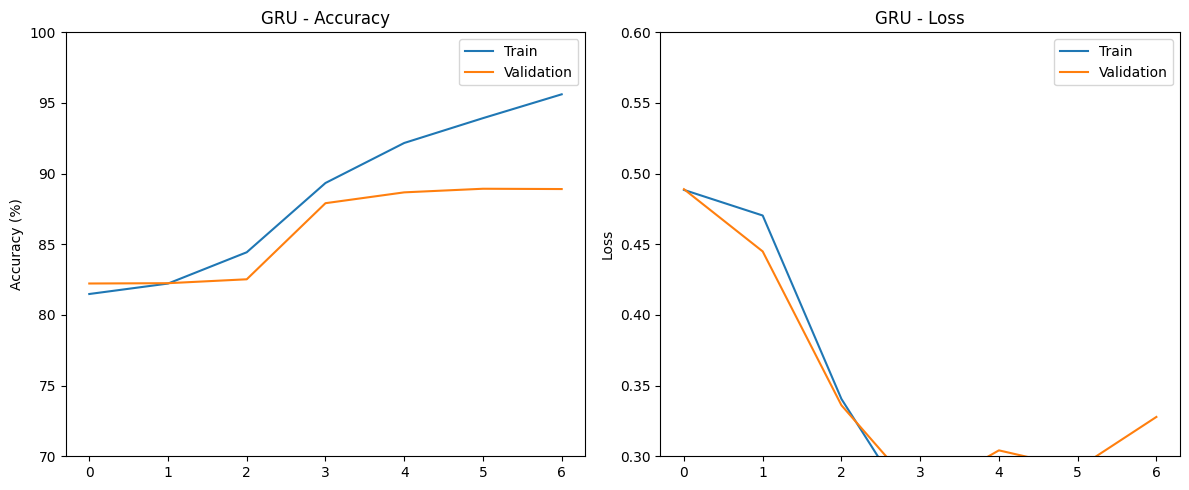

In [ ]:
# GRU
gru_model = build_model(model_type="GRU")
gru_model, gru_history = train_and_plot(gru_model, X_train, y_train, X_test, y_test, "GRU")

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Predict probabilities
    y_probs = model.predict(X_test).flatten()

    # Threshold to class labels
    y_pred = (y_probs >= 0.5).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)

    print(f"\n📌 {model_name} Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc}


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

📌 RNN Evaluation Metrics:
Accuracy:  0.8214
Precision: 0.8225
Recall:    0.9982
F1-Score:  0.9019
AUC-ROC:   0.5064


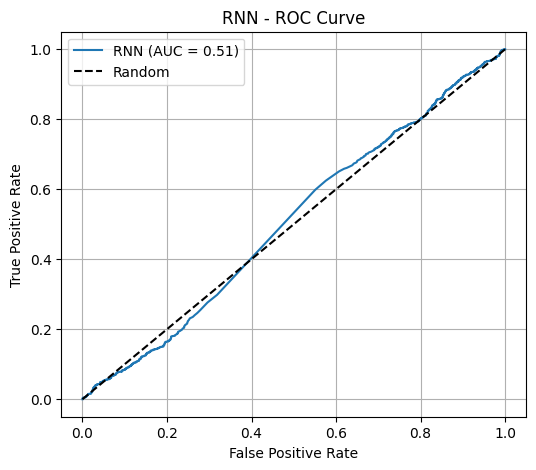

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

📌 LSTM Evaluation Metrics:
Accuracy:  0.8772
Precision: 0.9356
Recall:    0.9135
F1-Score:  0.9244
AUC-ROC:   0.9069


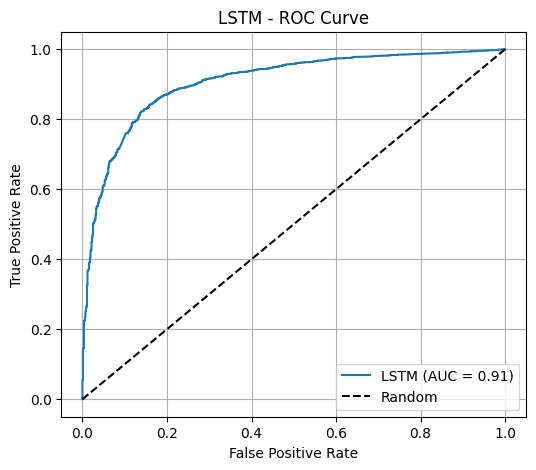

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

📌 GRU Evaluation Metrics:
Accuracy:  0.8791
Precision: 0.9464
Recall:    0.9042
F1-Score:  0.9248
AUC-ROC:   0.9178


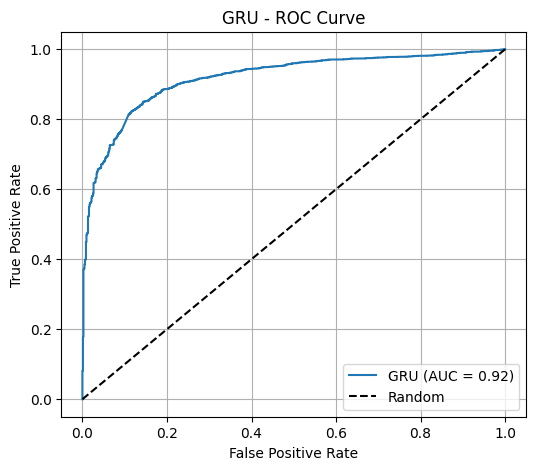

In [ ]:
rnn_results = evaluate_model(rnn_model, X_test, y_test, "RNN")
lstm_results = evaluate_model(lstm_model, X_test, y_test, "LSTM")
gru_results = evaluate_model(gru_model, X_test, y_test, "GRU")
